In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

print(tf.__version__)

datapath = 'data/'
df = pd.read_csv(datapath + 'paracetamol.csv')

print(df.dtypes.value_counts())
print(df.columns.tolist())
print('length of columns :', len(df.columns.tolist()))
print(df.count())
df.head()

1.12.0
float64    2
int64      1
object     1
dtype: int64
['quantity', 'kgPrice', 'dateUnix', 'dateIso']
length of columns : 4
quantity    2311
kgPrice     2311
dateUnix    2311
dateIso     2311
dtype: int64


,quantity,kgPrice,dateUnix,dateIso
0,1.0,0.750000,1483311600,01/01/2017
1,5986.0,3.039779,1483311600,01/01/2017
2,14137.2,3.356817,1483311600,01/01/2017
3,2500.0,6.887044,1483311600,01/01/2017
4,17789.2,3.401647,1483311600,01/01/2017


In [2]:
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    
    # Get Daily errors
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
  
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, 
           color='black', 
           label = 'Original data') 
    
    plt1.plot(predicted,
           color='blue', 
           label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')

    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

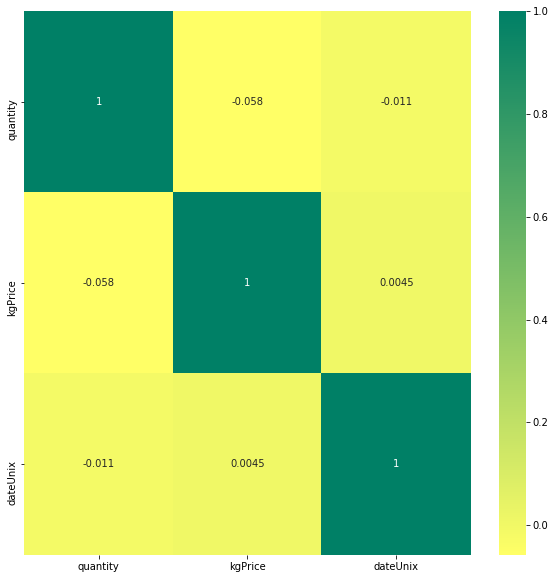

In [3]:
fig = plt.figure(figsize=(10,10))
data_corr = df.corr()
sns.heatmap(df.corr(), annot=True, cmap='summer_r')

Text(0.5,1,'quantity vs kgPrice')

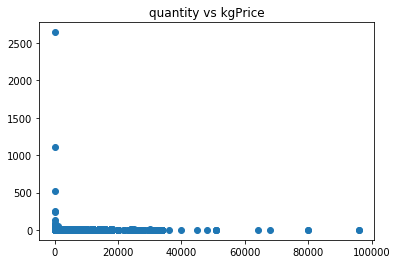

In [4]:
plt.scatter(df.quantity, df.kgPrice)
plt.title('quantity vs kgPrice')

Text(0.5,1,'dateUnix vs kgPrice')

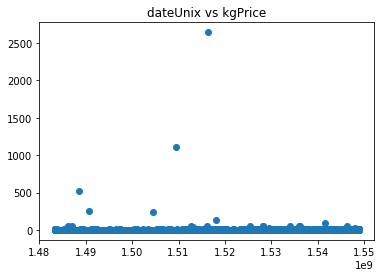

In [5]:
plt.scatter(df.dateUnix, df.kgPrice)
plt.title('dateUnix vs kgPrice')

Text(0.5,1,'dateUnix vs quantity')

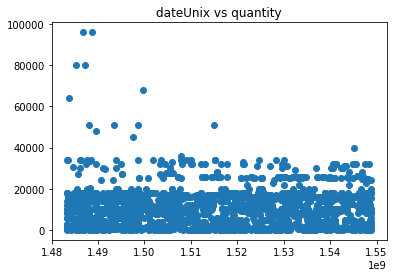

In [6]:
plt.scatter(df.dateUnix, df.quantity)
plt.title('dateUnix vs quantity')

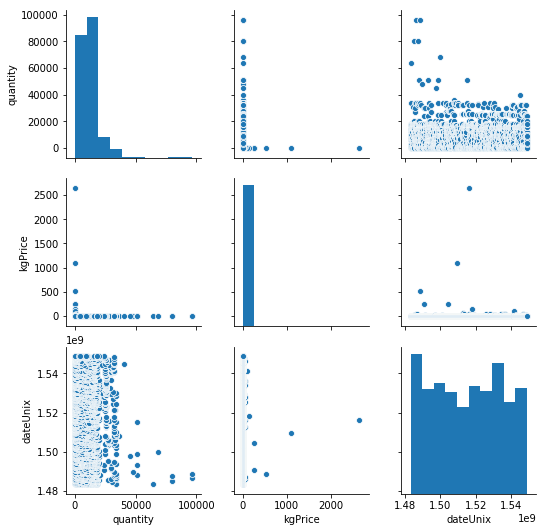

In [7]:
sns.pairplot(df)

In [8]:
dataset = df.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,quantity,kgPrice,dateUnix
0,1.0,0.750000,1483311600
1,5986.0,3.039779,1483311600
2,14137.2,3.356817,1483311600
3,2500.0,6.887044,1483311600
4,17789.2,3.401647,1483311600


In [9]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head()
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,3.448643,142727.8
1483398000,4.185645,34300.0
1483484400,4.050100,16000.0
1483570800,3.488540,92137.2
1483657200,3.203516,91000.0


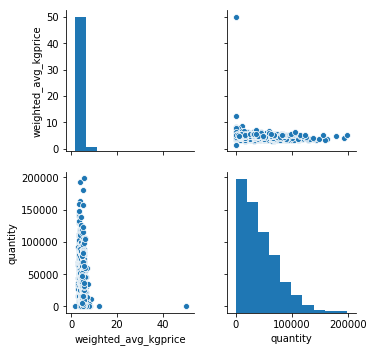

In [10]:
sns.pairplot(dataset_weighted)

In [11]:
#tlab = dataset_weighted.pop('weighted_avg_kgprice')
#tlab
features = dataset_weighted.drop('weighted_avg_kgprice', 1)
labels = dataset_weighted['weighted_avg_kgprice']

#features
#labels

In [12]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state = 0, shuffle=False)
#labels_test

In [13]:
train_stats = features_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
quantity,546.0,43204.922187,34909.847795,3.5,16727.9,35252.5,63673.4,198455.0


In [14]:
test_stats = features_test.describe()
test_stats = test_stats.transpose()
test_stats

,count,mean,std,min,25%,50%,75%,max
quantity,61.0,41799.059016,27798.47646,300.0,16100.0,39500.0,62000.0,105926.4


In [15]:
# used data standardization = (x - mean)/std
# data normalization = (x-min)/(max-min) 
def norm(x, stats):
    return (x - stats['min'])/(stats['max'] - stats['min'])
    #return (x - stats['mean']) / stats['std']

normed_train_data = norm(features_train, train_stats)
normed_test_data = norm(features_test, test_stats)
#normed_test_data

In [16]:
normtrain = normed_train_data.describe()
normtrain = normtrain.transpose()
normtrain

,count,mean,std,min,25%,50%,75%,max
quantity,546.0,0.217693,0.175911,0.0,0.084274,0.17762,0.320834,1.0


In [17]:
normtest = normed_test_data.describe()
normtest = normtest.transpose()
normtest

,count,mean,std,min,25%,50%,75%,max
quantity,61.0,0.392885,0.263177,0.0,0.149584,0.371119,0.584134,1.0


In [18]:
def build_model():
    #create model
    model = keras.Sequential() 
    
    #get number of columns in training data 
    n_cols = normed_train_data.shape[1]
    
    #add model layers
    model.add(layers.Dense(256, activation='relu', input_shape=(n_cols,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1))

    optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [19]:
model = build_model()

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
save_model_dir = 'models/'
model_filename = 'regression_basemodel_paracetamol_weightedavg_norm.h5'

In [22]:
checkpoint = ModelCheckpoint(filepath=save_model_dir + model_filename, verbose=1, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(normed_train_data, labels_train, epochs=1000, batch_size=50, verbose=0, callbacks=[early_stop, checkpoint], validation_split=0.2)


Epoch 00001: val_loss improved from inf to 30.34830, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00002: val_loss improved from 30.34830 to 29.91850, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00003: val_loss improved from 29.91850 to 29.42738, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00004: val_loss improved from 29.42738 to 28.84476, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00005: val_loss improved from 28.84476 to 28.13446, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00006: val_loss improved from 28.13446 to 27.26790, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00007: val_loss improved from 27.26790 to 26.21460, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00008: val_loss improved from 26.21460 to 24.94388, s


Epoch 00067: val_loss did not improve from 2.00544

Epoch 00068: val_loss did not improve from 2.00544

Epoch 00069: val_loss improved from 2.00544 to 1.98728, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00070: val_loss did not improve from 1.98728

Epoch 00071: val_loss did not improve from 1.98728

Epoch 00072: val_loss did not improve from 1.98728

Epoch 00073: val_loss did not improve from 1.98728

Epoch 00074: val_loss improved from 1.98728 to 1.92334, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00075: val_loss did not improve from 1.92334

Epoch 00076: val_loss did not improve from 1.92334

Epoch 00077: val_loss did not improve from 1.92334

Epoch 00078: val_loss did not improve from 1.92334

Epoch 00079: val_loss improved from 1.92334 to 1.90093, saving model to models/regression_basemodel_paracetamol_weightedavg_norm.h5

Epoch 00080: val_loss did not improve from 1.90093

Epoch 00081: val_loss did no

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
131,1.912687,1.262145,1.912687,5.337761,0.675922,5.337761,131
132,1.935520,1.270885,1.935520,5.333316,0.676307,5.333316,132
133,1.958964,1.280185,1.958964,5.333322,0.674573,5.333322,133
134,1.952901,1.277680,1.952901,5.332320,0.676297,5.332320,134
135,2.087307,1.328810,2.087307,5.335559,0.667967,5.335559,135


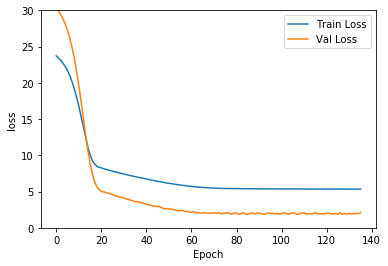

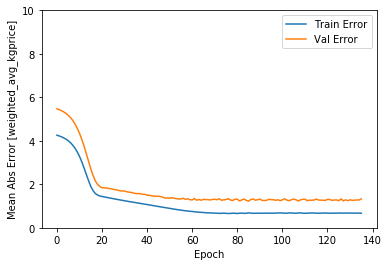

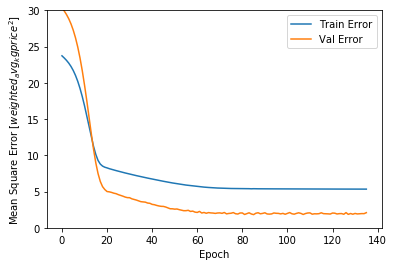

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0, 30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [weighted_avg_kgprice]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0, 10])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$weighted_avg_kgprice^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0, 30])
  plt.legend()
  
  plt.show()


plot_history(history)

In [25]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(normed_train_data, labels_train, epochs=1000, batch_size=50, verbose=0, callbacks=[early_stop, checkpoint], validation_split=0.2)


Epoch 00001: val_loss did not improve from 1.82001

Epoch 00002: val_loss did not improve from 1.82001

Epoch 00003: val_loss did not improve from 1.82001

Epoch 00004: val_loss did not improve from 1.82001

Epoch 00005: val_loss did not improve from 1.82001

Epoch 00006: val_loss did not improve from 1.82001

Epoch 00007: val_loss did not improve from 1.82001

Epoch 00008: val_loss did not improve from 1.82001

Epoch 00009: val_loss did not improve from 1.82001

Epoch 00010: val_loss did not improve from 1.82001

Epoch 00011: val_loss did not improve from 1.82001

Epoch 00012: val_loss did not improve from 1.82001

Epoch 00013: val_loss did not improve from 1.82001

Epoch 00014: val_loss did not improve from 1.82001

Epoch 00015: val_loss did not improve from 1.82001

Epoch 00016: val_loss did not improve from 1.82001

Epoch 00017: val_loss did not improve from 1.82001

Epoch 00018: val_loss did not improve from 1.82001

Epoch 00019: val_loss did not improve from 1.82001

Epoch 00020

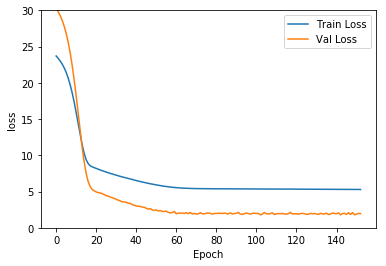

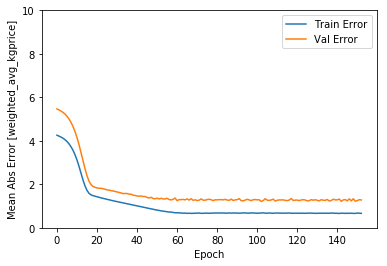

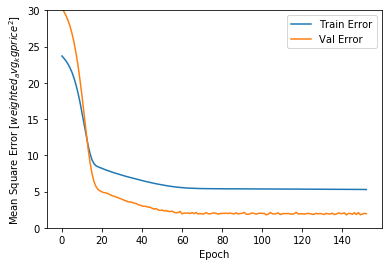

In [26]:
plot_history(history)

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, labels_test, verbose=1)
print("loss: {:5.2f} ".format(loss))
print("mse: {:5.2f} ".format(mse))
print("Testing set Mean Abs Error: {:5.2f} weighted_avg_kgprice".format(mae))
#print(loss)

61/61 [==============================] - 0s 81us/step
loss:  2.08 
mse:  2.08 
Testing set Mean Abs Error:  1.27 weighted_avg_kgprice


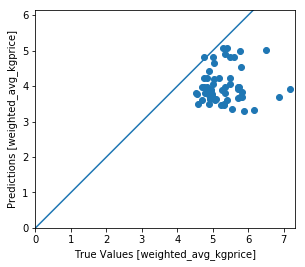

In [28]:
test_predictions = model.predict(normed_test_data).flatten()
#test_predictions = model.predict(features_test).flatten()

plt.scatter(labels_test, test_predictions)
plt.xlabel('True Values [weighted_avg_kgprice]')
plt.ylabel('Predictions [weighted_avg_kgprice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

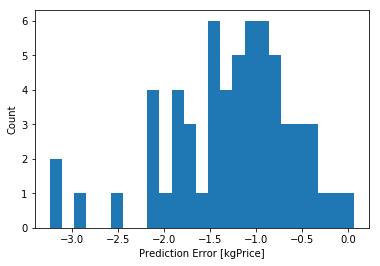

In [29]:
error = test_predictions - labels_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [kgPrice]")
_ = plt.ylabel("Count")

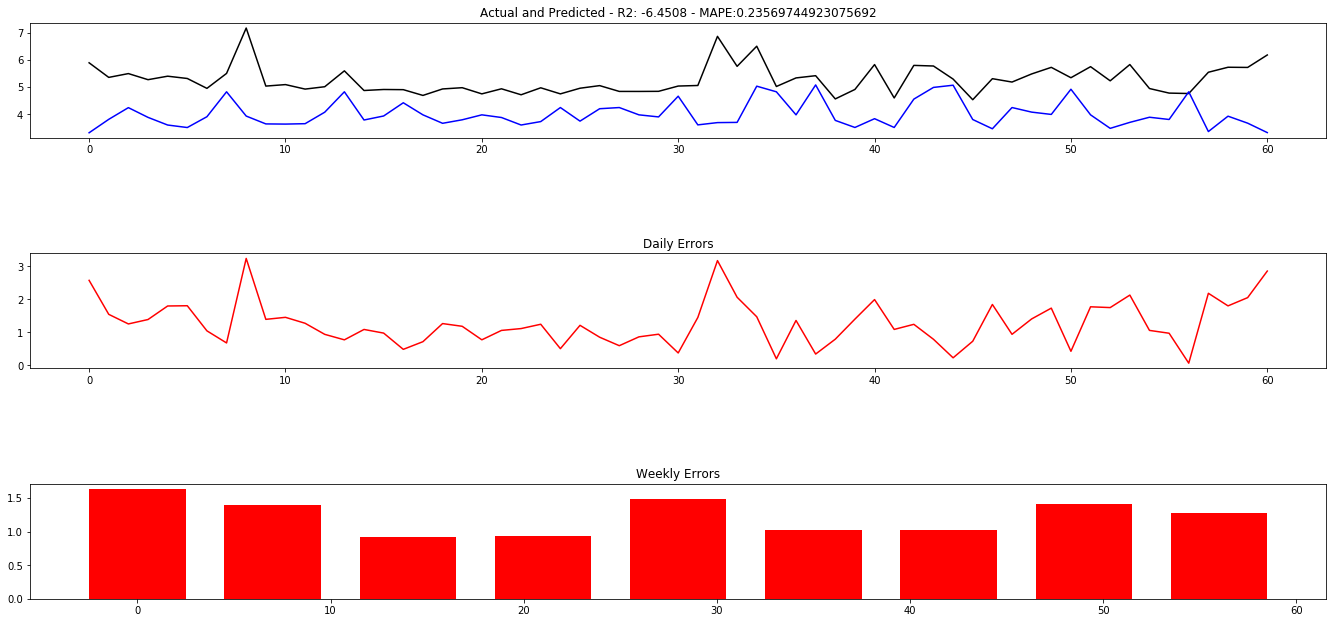

In [30]:
actual = []
for x in range(0, len(labels_test)):
    actual.append(labels_test.iloc[x])

actual = np.asarray(actual, dtype=np.float32)
#print(actual)
plot_prediction(actual, test_predictions)


In [31]:
#test_predictions = model.predict(normed_test_data).flatten()
#test_predictions = model.predict(features_test).flatten()
print("Predicted \t True value")
for x in range(0, len(test_predictions)):
  print("{:.3f} \t\t {:.3f}".format(test_predictions[x], labels_test.iloc[x])) 
  #print("True value: {}".format(labels_test.iloc[x])) 
#print(test_predictions)

Predicted 	 True value
3.312 		 5.891
3.807 		 5.353
4.238 		 5.493
3.879 		 5.269
3.597 		 5.398
3.505 		 5.313
3.904 		 4.949
4.822 		 5.500
3.928 		 7.173
3.638 		 5.033
3.632 		 5.088
3.647 		 4.922
4.070 		 5.009
4.822 		 5.594
3.782 		 4.870
3.931 		 4.907
4.418 		 4.901
3.973 		 4.689
3.661 		 4.927
3.790 		 4.974
3.973 		 4.746
3.875 		 4.933
3.598 		 4.712
3.724 		 4.970
4.242 		 4.746
3.741 		 4.954
4.198 		 5.050
4.242 		 4.836
3.973 		 4.836
3.896 		 4.839
4.660 		 5.034
3.603 		 5.055
3.687 		 6.865
3.694 		 5.760
5.030 		 6.503
4.822 		 5.018
3.973 		 5.334
5.076 		 5.416
3.768 		 4.560
3.508 		 4.909
3.831 		 5.826
3.507 		 4.596
4.552 		 5.796
4.984 		 5.773
5.065 		 5.291
3.800 		 4.530
3.459 		 5.306
4.242 		 5.182
4.073 		 5.480
3.988 		 5.723
4.916 		 5.341
3.973 		 5.748
3.475 		 5.227
3.696 		 5.827
3.884 		 4.943
3.802 		 4.775
4.822 		 4.759
3.357 		 5.543
3.923 		 5.727
3.666 		 5.720
3.318 		 6.180
